In [1]:
# import everything is needed from torch and pysteps
import torch
from model import model
from pysteps.noise.fftgenerators import initialize_nonparam_2d_fft_filter
from pysteps.noise.fftgenerators import generate_noise_2d_fft_filter
from pysteps.postprocessing.probmatching import nonparam_match_empirical_cdf 
import numpy as np
from scipy.interpolate import interp1d
# import the pre-trained weigths for determinitic PredNet
checkpoint = torch.load('./prednet-v3.pth',map_location={'cuda:0':'cpu'})
model.load_state_dict(checkpoint['model_state_dict'])

Pysteps configuration file found at: /Users/marino/.pysteps/pystepsrc



<All keys matched successfully>

In [2]:
# define some procedures

amount=np.array([0,1,2,4,8,12,16,24,32,40,48,56,64,80,100])
classes=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
class2rainrate  = interp1d(classes, amount, kind='linear',bounds_error=False,fill_value=(0,100))
rainrate2class  = interp1d(amount, classes, kind='linear',bounds_error=False,fill_value=(0,14))

def cdf_adjusted_0(x,y):
    x_cal=nonparam_match_empirical_cdf(x,y)
    return x_cal

def downscale_factors(frc,obs,num_realizations,iseed):
    # la generazione parametrica (isotropa) sembra essere più stabile rispetto a quella non parametrica
    Fnp_frc = initialize_nonparam_2d_fft_filter(frc)
    Fnp_obs = initialize_nonparam_2d_fft_filter(obs)
    down_fact=[]
    for m in range(num_realizations):
        seed=m*13+iseed*17 # aggiunge dipendenza del seed dal membro
        rrr = np.exp(generate_noise_2d_fft_filter(Fnp_obs, seed=seed))
        rsa = np.exp(generate_noise_2d_fft_filter(Fnp_frc, seed=seed))
        down_fact.append(rrr/rsa)
    return np.array(down_fact)

def PredNet_deterministic(train,forecast_steps=1):
    time_steps=train.shape[0]
    train=np.expand_dims(train[:],0) # tensorize train data to be used as input for torch
    o = model(torch.from_numpy(train[0,:]).unsqueeze(0), time_steps=time_steps, forecast_steps=forecast_steps, mode='forecast')
    o_np = o[0].cpu().detach().numpy()
    trch_12=class2rainrate((o_np[:,0])*15)
    return trch_12

def pick_event_24(ti):
# returns an array of shape (36,1,96,96) starting at time ti with rr classes
    radardata_test=np.zeros([24,1,96,96])
    dir_data='./KyotoRainRate/'
    for i in range(24):
        radardata_test[i]=np.load(f'{dir_data}/{ti+i}.npz')['arr_0']
    return radardata_test/15

nm=2
events=np.load('./all_events_4.npy')
print(len(events))

In [4]:
# implement stochastic version of PredNet
nm=2
ie=56611
train_pert=np.zeros([nm,24,96,96])
NN=np.zeros([nm,12,96,96])
train=pick_event_24(ie) # radar_test returns an array of shape (24,1,96,96)
precip=class2rainrate(train[:,0]*15) # save in array precip observed values during learning ad nowcast period
NN_det=PredNet_deterministic(train[:12],forecast_steps=24) #deterministic nowcast
# generate perturbed train scenarios as noise aded to prednet representation of precip
# we are simulating a process of data assimilation: result is an almost perfect ensemble 
# in the assimilation window of lenghts one hour
#down_fact=downscale_factors(precip[9:12],NN_det[9:12],nm,ie)
for m in range(nm):
    train_pert[m,0]=precip[0].copy() # for t=0 we don't have a deterministic forecast
for f in range(0,12): # an ensemble is built adding noise at scales not resolved by the PredNet model
    down_fact=downscale_factors(precip[9:12],NN_det[9:12],nm,f)
    train_pert[:,f]=NN_det[f]*down_fact
    for m in range(0,nm):
        train_pert[m,f]=cdf_adjusted_0(train_pert[m,f],precip[f])
train_pert=rainrate2class(train_pert[:,:,None])/15
# now evolve scenarios with PredNet
for f in range(12):
    for m in range(nm): # NN: stochastic prednet
        NN[m,f]=PredNet_deterministic(train_pert[m,:12+f],forecast_steps=1)[-1]
    # at each time step we impose ensemble mean to be equal to the prednet deterministic forecast
    # noise is added compatible with unresolved scales
    # cdf is adjusted to be equal to the last observed field
    ens_mean=np.mean(NN[:,f],axis=0) 
    mask=ens_mean>0                    
    for m in range(nm):                
        NN[m,f][mask]=NN[m,f][mask]*NN_det[12+f][mask]/ens_mean[mask]
        NN[m,f]=cdf_adjusted_0(NN[m,f]*downscale_factors(NN_det[9:12],precip[9:12],1,f*nm+m),precip[11])
        train_pert[m,12+f,0]=rainrate2class(NN[m,f])/15
    print(ie,m,f,mask.sum(),end='\r')

In [5]:
import matplotlib.pyplot as plt

def tresh_to_nan(x,tresh=0):
    x=x.copy()
    x[x<=tresh]=np.nan
    return x
def plot_precip(x,vmax=8,title=''):
    plt.figure(figsize=(16,3))
    for f in range(len(x)):
        plt.subplot(1,12,f+1)
        plt.imshow(tresh_to_nan(x[f]),vmax=vmax)
        plt.title(title)
        plt.axis('off')
    plt.savefig(title+'.png')

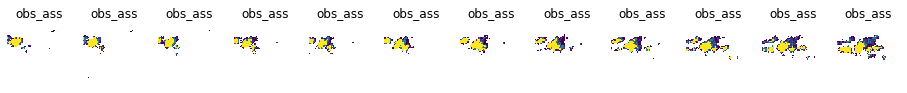

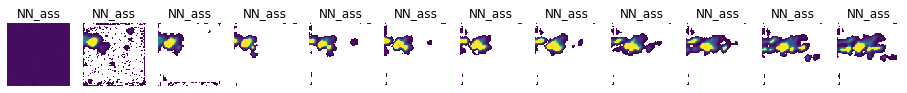

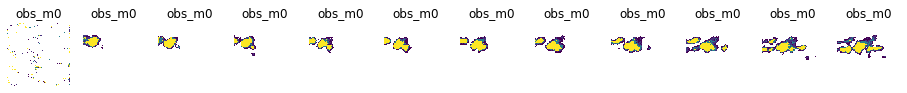

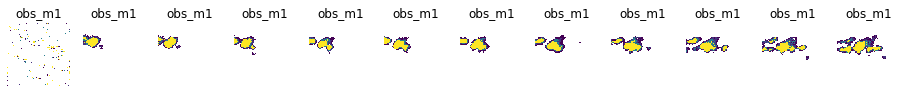

In [8]:
#plot observations and scenarios pre-nowcast 
plot_precip(precip[:12],title='obs_ass')
plot_precip(NN_det[:12],title='NN_ass')
for m in range(nm):
    plot_precip(class2rainrate(15*train_pert[m,:12,0]),title='obs_m'+str(m))

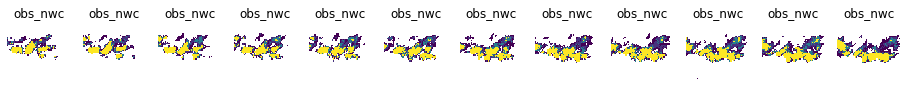

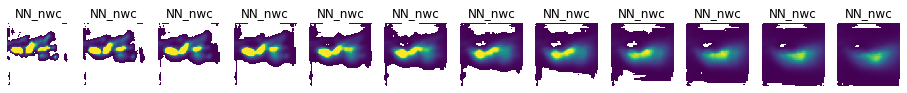

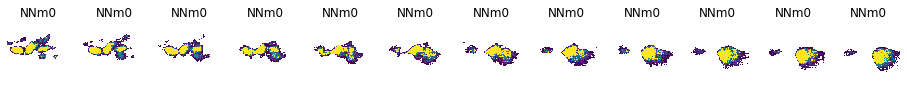

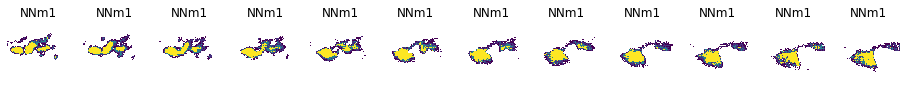

In [9]:
# plot deterministi and stochastic PredNet npwcasts together with observation
plot_precip(precip[12:24],title='obs_nwc')
plot_precip(NN_det[12:24],title='NN_nwc')
for m in range(nm):
    plot_precip(NN[m,:12],title='NNm'+str(m))